# Order Delivery Time Prediction

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [67]:
# Import essential libraries for data manipulation and analysis

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [68]:
# Importing the file porter_data_1.csv
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porter_data_1.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20


In [69]:
#check shape
df.shape

(175777, 14)

In [70]:
df.columns

Index(['market_id', 'created_at', 'actual_delivery_time',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance'],
      dtype='object')

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

In [71]:
df.dtypes

,0
market_id,float64
created_at,object
actual_delivery_time,object
store_primary_category,int64
order_protocol,float64
total_items,int64
subtotal,int64
num_distinct_items,int64
min_item_price,int64
max_item_price,int64


##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [72]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Verify the conversion
print(df[['created_at', 'actual_delivery_time']].dtypes)



created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [73]:
# Convert categorical features to category type

categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verify the conversion
print(df[categorical_columns].dtypes)

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [74]:
# Calculate time taken in minutes

df['delivery_time_mins'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Preview the new column
print(df[['created_at', 'actual_delivery_time', 'delivery_time_mins']].head())


           created_at actual_delivery_time  delivery_time_mins
0 2015-02-06 22:24:17  2015-02-06 23:11:17                47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [75]:
# Extract the hour and day of week from the 'created_at' timestamp

df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek


# Create a categorical feature 'isWeekend'

df['isWeekend'] = df['created_at'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
df['isWeekend'] = df['isWeekend'].astype('category')

df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,delivery_time_mins,order_hour,order_dayofweek,isWeekend
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3,0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1,0


In [76]:
# Drop unnecessary columns

# Drop raw timestamp columns
df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

df.head()

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,delivery_time_mins,order_hour,order_dayofweek,isWeekend
0,1.0,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0,22,4,0
1,2.0,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0,21,1,0
2,2.0,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0,0,0,0
3,1.0,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0,3,3,0
4,1.0,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0,2,1,0


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [77]:
# Define target variable (y) and features (X)
y = df.pop('delivery_time_mins')
X = df

X.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour', 'order_dayofweek',
       'isWeekend'],
      dtype='object')

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [106]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Display the shape of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [79]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='category').columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_dayofweek']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

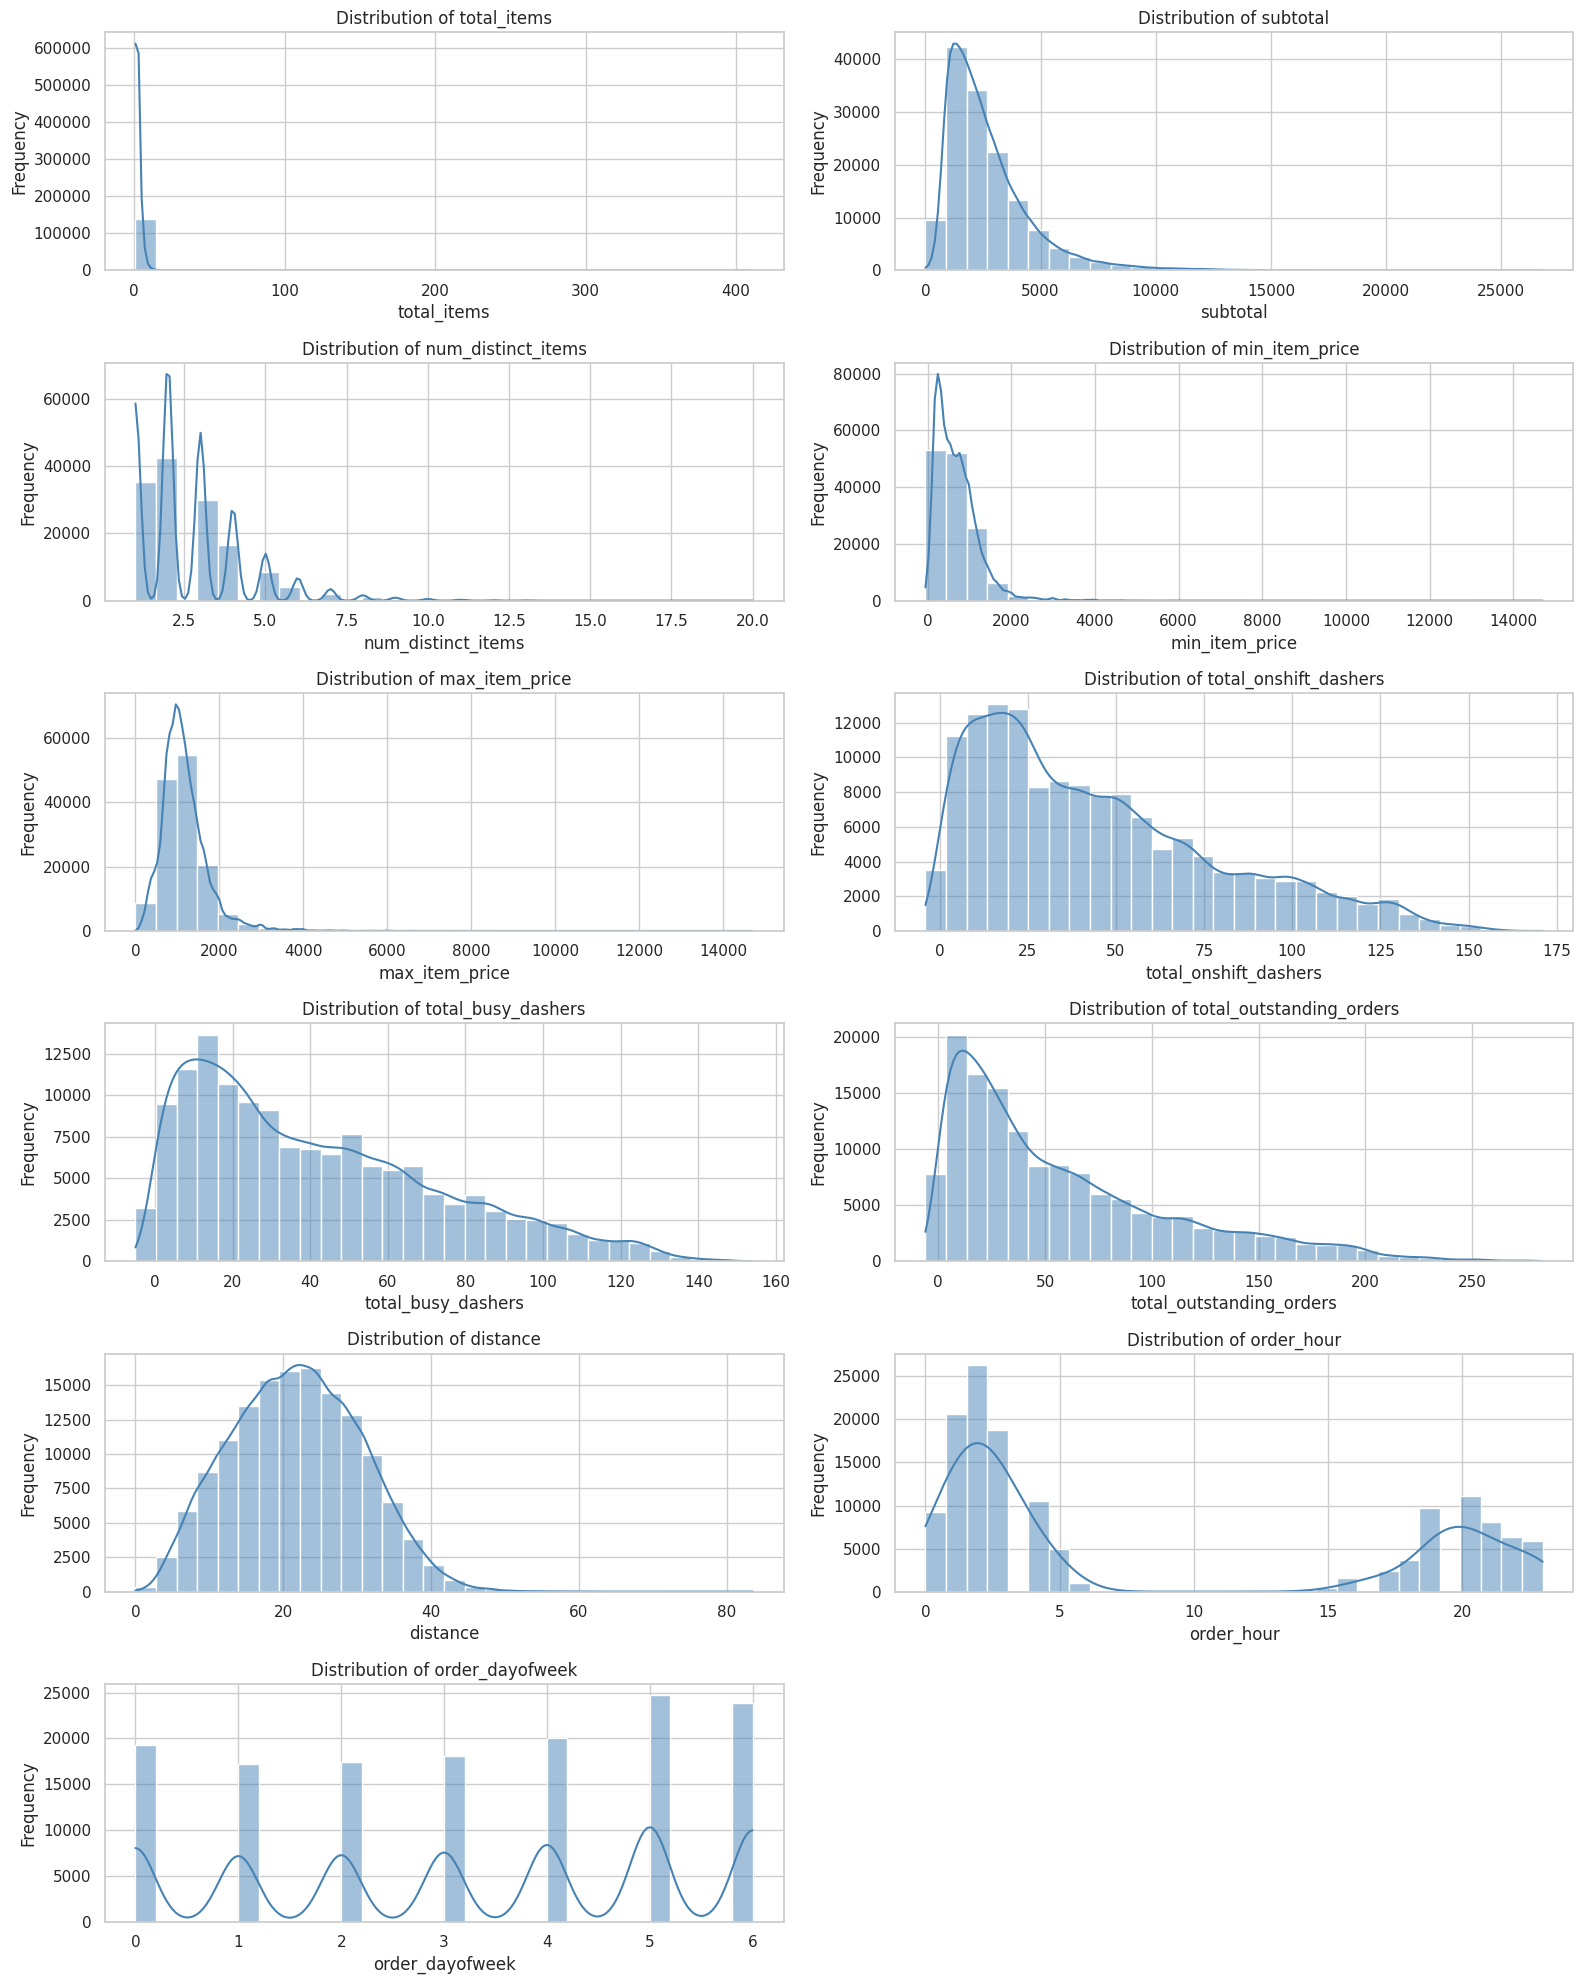

In [108]:
# Plot distributions for all numerical columns


# Set up plot style
sns.set(style='whitegrid')
plt.figure(figsize=(16, 24))

# Plot distribution for each numerical column
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

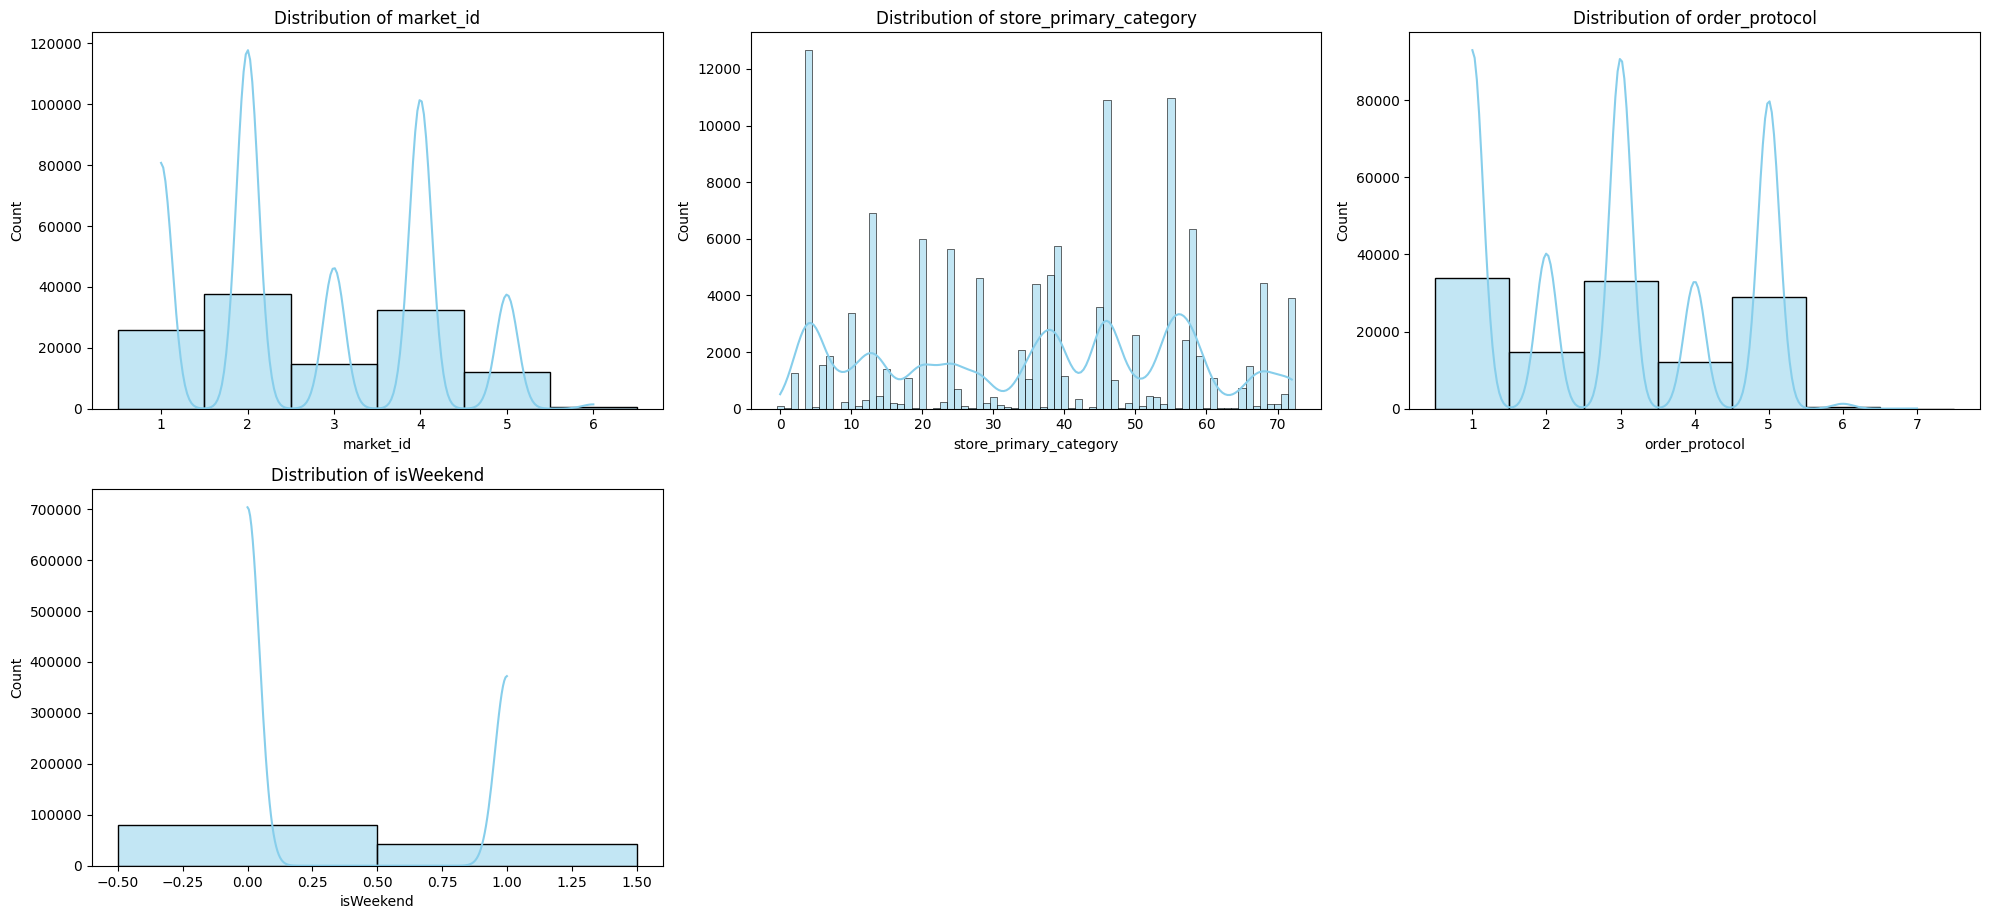

In [81]:
# Distribution of categorical columns

plt.figure(figsize=(20, 18))
for i, col in enumerate(categorical_cols):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X_train[col],kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

In [82]:
# Distribution of time_taken



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [83]:
# Scatter plot to visualise the relationship between time_taken and other features



In [84]:
# Show the distribution of time_taken for different hours



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

In [85]:
# Plot the heatmap of the correlation matrix



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [86]:
# Drop 3-5 weakly correlated columns from training dataset



#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [87]:
# Boxplot for time_taken



##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [88]:
# Handle outliers



## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [89]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [90]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [91]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [92]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [93]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [94]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [95]:
# Import libraries



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [96]:
# Apply scaling to the numerical columns



Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [97]:
# Create/Initialise the model


In [98]:
# Train the model using the training data


In [99]:
# Make predictions


In [100]:
# Find results for evaluation metrics



Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [101]:
# Loop through the number of features and test the model



In [102]:
# Build the final model with selected number of features



## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [103]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram



[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [104]:
# Compare the scaled vs unscaled features used in the final model



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [105]:
# Analyze the effect of a unit change in a feature, say 'total_items'



Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>